In [2]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random

import pandas as pd
import rpy2.rinterface as rinterface
import rpy2.robjects as robjects

import tqdm
import seaborn as sns
import scipy.stats as stats

from itertools import compress
from Bio import motifs
from Bio.Seq import Seq #, IUPAC
from collections import Counter
from os import listdir
from os.path import join
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from scipy.stats import ks_2samp
from statistics import mean, median

import session_info

%load_ext rpy2.ipython
%matplotlib inline
pandas2ri.activate()
plt.ioff()

In [3]:
session_info.show()

# Introduction

This script combines both python and R components and uses the Kumasaka et al dataset as a starting point. It first defines SNPs that are likely to be under cooperative control and also generates control ('no-effect') SNPs.

1) identify a set of SNPs that are 

        * caQTL enhancers that have a SNP inside the enhancer that alters enhancer-wide accessibility 
        * no-effect enhancers where no there is a SNP that does not lead to large changes
        
2) once identified, we extract the two neighboring peaks or, in case the enhancer is within the 'dag' file, we will associates its 'dependents'.
        
        * identify all caQTL enhancers in the first column of the 'dag' file  (CM-leads) and extract their dependents 2nd column in 'dag' file
        * add the two neighbors of all caQTL enhancers not in the 'dag' file and of all no-effect enhancers
        


Many functions in this script are sourced from the following script:
**/home/kribelba/SVRAW1/kribelba/scripts/Enhancer_hierarchy/GM12787_ChIP_ASB/current_version/functions_Enh_hierarchy_GM12878_mechansims_analysis_2021_11_27.R**

## Switch to R

In [66]:
%%R

## genomic manipulation
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library("BSgenome.Hsapiens.UCSC.hg19"))
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(rtracklayer))
suppressPackageStartupMessages(library(GenomicFeatures))
suppressPackageStartupMessages(library("TxDb.Hsapiens.UCSC.hg19.knownGene"))
suppressPackageStartupMessages(library('AnnotationHub'))
suppressPackageStartupMessages(library(org.Hs.eg.db))
suppressPackageStartupMessages(library(GO.db))
suppressPackageStartupMessages(library(ChIPseeker))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(Rsubread))
suppressPackageStartupMessages(library("tximport"))
suppressPackageStartupMessages(library("readr"))
suppressPackageStartupMessages(library(biomaRt))
suppressPackageStartupMessages(library(vcfR))
## visualisation
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(gplots))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(plotly))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library("wesanderson",lib.loc="/home/kribelba/R_libs/"))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(dplyr))

# custom functions
makeTr = function(someColor, alpha=100) scales::alpha(someColor, alpha/100)

source("/home/kribelba/SVRAW1/kribelba/scripts/Enhancer_hierarchy/GM12787_ChIP_ASB/For_submission_April_2023/custom_functions.R")

## color palettes
enh_cols = c(wes_palette("Moonrise1")[3],wes_palette("Rushmore1")[4],wes_palette("Rushmore1")[3])
class_cols=c(makeTr('indianred2',80),makeTr(wes_palette('Moonrise1')[2],80),makeTr(wes_palette("Cavalcanti1")[3],80),makeTr(wes_palette('GrandBudapest2')[4],80))


In [12]:
%%R
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.7 (Ootpa)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] lubridate_1.9.2                        
 [2] forcats_1.0.0                          
 [3] stringr_1.5.0                          
 [4] dplyr_1.1.1                            
 [5] purrr_1.0.1                            
 [6] tidyr_1.3.0                            
 [7] tibble_3.2.1        

In [ ]:
%%R
## load in Kumasaka et al tables
## change path to local directory
dag = read.table("/home/.../dag.tsv")
peaks = read.table("/home/.../peaks.tsv",header=T)
vars = read.table("/home/.../lead_caQTL_variants.tsv",header=T)


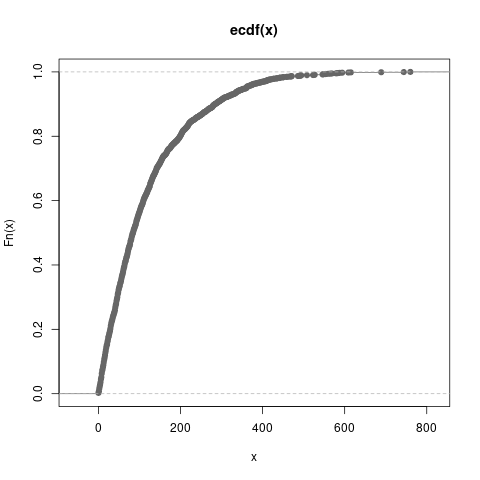

In [21]:
%%R


## 2 ) Defining the different SETS: CM, LOCALS and SNPs with no change and no CM
## Kumasaka et el. defintions
## 1) CMs using first column in dag file
allCMLEAD_tab = get_peak_var_tab(peaks = peaks,vars,unique(dag[,1]))
GR_allCMLEAD = make_GR_from_df(allCMLEAD_tab,c("Chr","Pos_Left","Pos_Right"))

## Get 2nd order depenent peaks 
allCMDEP_tab = get_peak_var_tab(peaks = peaks,vars,unique(dag[,2]))
GR_allCMDEP = make_GR_from_df(allCMDEP_tab,c("Chr","Pos_Left","Pos_Right"))


# subsetting CM-Leads to generate data that is very pure, SNP in peak, P_Lead * p_caQTL >0.5 & only Single Nucleotide poly
SNP_f = sapply(allCMLEAD_tab$Ref,function(x){nchar(x)==1}) & sapply(allCMLEAD_tab$Alt,function(x){nchar(x)==1})

CMLEADS_SNPinpeak_2 = allCMLEAD_tab[(allCMLEAD_tab$P_Lead>0.7 &  allCMLEAD_tab$P_caQTL>0.7) & allCMLEAD_tab$Inside_Peak==1 & SNP_f,]
GR_CMLEADS_SNPinpeak_2 = make_GR_from_df(CMLEADS_SNPinpeak_2,c("Chr","Pos_Left","Pos_Right"))

plot.ecdf(CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center,col="grey40")



In [22]:
%%R
# Gaf full LOCAL Lead tab & GR,  the neighbor peak exclusion was added only for the Jan -14 update table 

pot_local_peak_ids = vars$Peak[vars$P_Lead>0.7 & !(vars$Peak %in% c(dag[,1],dag[,2],dag[,3],dag[,4],dag[,5])) 
                               & !(vars$Peak %in% (c(dag[,1],dag[,2],dag[,3],dag[,4],dag[,5])+1)) &  !(vars$Peak %in% (c(dag[,1],dag[,2],dag[,3],dag[,4],dag[,5])-1))
                                 & vars$Inside_Peak==1 & sapply(vars$Ref,function(x){nchar(x)==1}) & sapply(vars$Alt,function(x){nchar(x)==1})  ]

potLOCAL_tab = get_peak_var_tab(peaks = peaks,vars,pot_local_peak_ids)

LOCAL_tabf_2 = potLOCAL_tab[potLOCAL_tab$P_Lead >0.7 &  potLOCAL_tab$P_caQTL > 0.7 & potLOCAL_tab$Inside_Peak==1,]
GR_local_2 = make_GR_from_df(LOCAL_tabf_2,c("Chr","Pos_Left","Pos_Right"))




In [27]:
%%R
#  non-causal peaks  the neighbor peak exclusion was added only for the Jan -14 update table 
pot_noncausal_peak_ids = vars$Peak[vars$P_Lead<0.5 & !(vars$Peak %in% c(dag[,1],dag[,2],dag[,3],dag[,4],dag[,5]))  & !(vars$Peak %in% LOCAL_tabf_2$Peak) 
                                   & !(vars$Peak %in% c(LOCAL_tabf_2$Peak+1)) & !(vars$Peak %in% c(LOCAL_tabf_2$Peak-1)) 
                                   & !(vars$Peak %in% (c(dag[,1],dag[,2],dag[,3],dag[,4],dag[,5])+1)) &  !(vars$Peak %in% (c(dag[,1],dag[,2],dag[,3],dag[,4],dag[,5])-1))
                                    & vars$Inside_Peak==1 & sapply(vars$Ref,function(x){nchar(x)==1}) & sapply(vars$Alt,function(x){nchar(x)==1})  ]


In [28]:
%%R
## select of potential no-effect peaks
NONLEAD_tab = get_peak_var_tab(peaks,vars,pot_noncausal_peak_ids)
NONLEAD_tabf0502 = NONLEAD_tab[NONLEAD_tab$P_Lead < 0.5 & NONLEAD_tab$P_caQTL<0.2 & NONLEAD_tab$Inside_Peak==1,]

print(dim(NONLEAD_tabf0502))

[1] 56791    25


In [29]:
%%R
print(dim(NONLEAD_tabf0502))
print(length(unique(NONLEAD_tabf0502$Peak)))

print(dim(LOCAL_tabf_2))
print(length(unique(LOCAL_tabf_2$Peak)))
print(dim(CMLEADS_SNPinpeak_2))
print(length(unique(CMLEADS_SNPinpeak_2$Peak)))

[1] 56791    25
[1] 56369
[1] 7625   25
[1] 7625
[1] 2051   25
[1] 2051


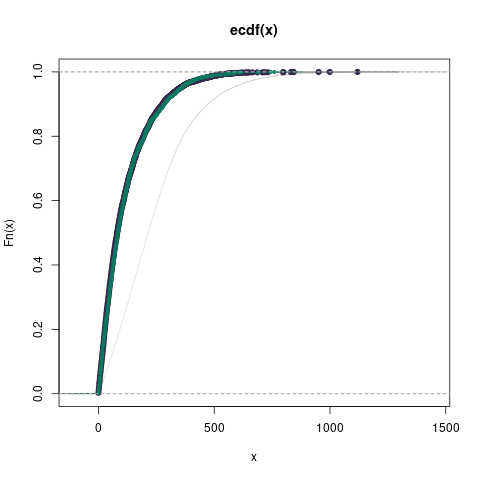

In [35]:
%%R
plot.ecdf(NONLEAD_tabf0502$Dist_SNP_to_peak_center[!duplicated(NONLEAD_tabf0502$Peak)],col=enh_cols[1],cex=1.2)
plot.ecdf(LOCAL_tabf_2$Dist_SNP_to_peak_center[!duplicated(LOCAL_tabf_2$Peak)],col=enh_cols[2],add=T)
plot.ecdf(CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center[!duplicated(CMLEADS_SNPinpeak_2$Peak)],col=enh_cols[3],add=T,cex=0.6)

## the no-effect peaks are much further away from the peak center --> pre-sample

### Pre-Sampling the no-effect peaks to be similar in SNP-to-peak-center ditance to the larger set of LOCAL caQTL peaks

[1] 7625
[1] 7625   25
[1] 7611

	Wilcoxon rank sum test with continuity correction

data:  (LOCAL_tabf_2$Dist_SNP_to_peak_center) and (NONLEAD_tabff$Dist_SNP_to_peak_center)
W = 27480507, p-value = 4.958e-09
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  (LOCAL_tabf_2$Dist_SNP_to_peak_center) and (CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center)
W = 7704154, p-value = 0.3046
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  (CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center) and (NONLEAD_tabff$Dist_SNP_to_peak_center)
W = 7518149, p-value = 0.007299
alternative hypothesis: true location shift is not equal to 0

[1] 7625
[1] 7625   25


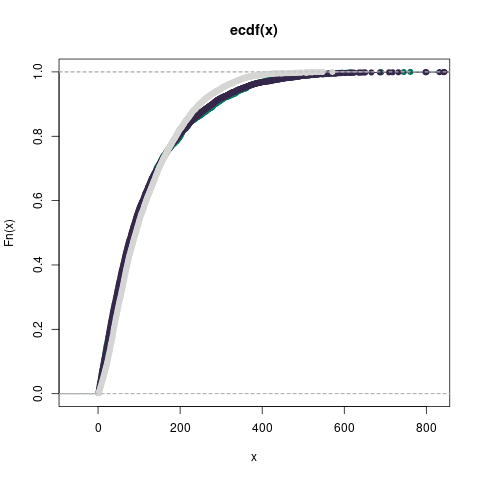

In [36]:
%%R
###----------------------------------------------
## matching 

# filter Noncausal to match SNP centrality
centr = NONLEAD_tabf0502$Dist_SNP_to_peak_center
uloc = unique(LOCAL_tabf_2$Peak)
ulocdis = LOCAL_tabf_2$Dist_SNP_to_peak_center[match(uloc,LOCAL_tabf_2$Peak)]
print(length(uloc))
min_v=c()
for (i in 1:length(ulocdis)){
  w=which.min(abs(centr-ulocdis))
  min_v[i]=w
  centr[w]=1000000 # set to large number to avoid resampling
}

NONLEAD_tabff = NONLEAD_tabf0502[min_v,]
print(dim(NONLEAD_tabff))
print(length(unique(NONLEAD_tabff$Peak)))

plot.ecdf((CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center+1),col=enh_cols[3])
plot.ecdf((LOCAL_tabf_2$Dist_SNP_to_peak_center+1),add=T,col=enh_cols[2])
plot.ecdf((NONLEAD_tabff$Dist_SNP_to_peak_center+1),add=T,col=enh_cols[1])

print(wilcox.test((LOCAL_tabf_2$Dist_SNP_to_peak_center),(NONLEAD_tabff$Dist_SNP_to_peak_center)))
print(wilcox.test((LOCAL_tabf_2$Dist_SNP_to_peak_center),(CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center)))
print(wilcox.test((CMLEADS_SNPinpeak_2$Dist_SNP_to_peak_center),(NONLEAD_tabff$Dist_SNP_to_peak_center)))

GR_nonleads = make_GR_from_df(NONLEAD_tabff,c("Chr","Pos_Left","Pos_Right"))
print(length(GR_nonleads))
print(dim(NONLEAD_tabff))
## save R objects 
#save(Gaf_LEADS_SNPinpeak_2,Gaf_LOCAL_tabf_2,Gaf_NONLEAD_tabff,file="home/.../indiviudal_peak_tables_with_SNP_enhancers.RData"

### Combine everything to a complete table and add neighboring peaks of CM-dependents

In [38]:
%%R
## First look independent of SNPs in GM for a general characterization
vcm_Lids = unique(CMLEADS_SNPinpeak_2$Peak)

LEDE_tab_vcm_1pair_only = CMLEADS_SNPinpeak_2[match(vcm_Lids,CMLEADS_SNPinpeak_2$Peak),]

joint_tab = rbind(LEDE_tab_vcm_1pair_only,LOCAL_tabf_2,NONLEAD_tabff)

# get Peak IDs for dependent peaks
CMlead_dep_list_a = tapply(dag[,2],dag[,1],c)

#local
LOCAL_nei_list_a = lapply(LOCAL_tabf_2$Peak,function(u){
  c((u-1),(u+1))})
names(LOCAL_nei_list_a)=LOCAL_tabf_2$Peak

#nonlead
NONLEAD_nei_list_a = lapply(NONLEAD_tabff$Peak,function(u){
  c((u-1),(u+1))})
names(NONLEAD_nei_list_a)=NONLEAD_tabff$Peak

## join all neighbor lists
DE_list_a = c(CMlead_dep_list_a,LOCAL_nei_list_a,NONLEAD_nei_list_a)

## combine lead and dep info
LEDE_taba = add_dep_info(joint_tab,DE_list_a,vars,peaks)


In [42]:
%%R
print(head(LEDE_taba))
print(head(joint_tab))
print(dim(LEDE_taba))
print(length(unique(LEDE_taba$Peak)))


      Peak  Chr     Pos        RsID Ref Alt     AF Inside_Peak    P_Lead
7        7 chr1  565286   rs1578391   C   T 0.5978           1 0.9985614
222    213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.1  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.2  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
287    277 chr1 3820005  rs10909828   G   A 0.3450           1 0.9999658
296    286 chr1 4327635   rs2101576   C   T 0.5500           1 0.9997817
           Beta       SE  Log10_BF Chr Pos_Left Pos_Right Peak      GC
7      0.886884 0.188153  3.085214   1   565005    565787    7 43.0396
222    0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.1  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.2  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
287   -0.654595 0.049849 19.692796   1  3819984   3820189  277 58.7379
296   -0.666789 0.041505 25.445000   1  4327332   4328105  286 

## Add  additional information

#### distance between peak pairs

In [46]:
%%R

LEDE_taba$LD_peak_dist = abs(LEDE_taba$Peak_center - LEDE_taba$dep_Peak_center)

vcm_Lids = CMLEADS_SNPinpeak_2$Peak
loc_Lids = LOCAL_tabf_2$Peak
nl_Lids = NONLEAD_tabff$Peak

LEDE_taba$enh_subcategory = "notassigned"
LEDE_taba$enh_subcategory[LEDE_taba$Peak %in%CMLEADS_SNPinpeak_2$Peak ] = "CM"
LEDE_taba$enh_subcategory[LEDE_taba$Peak %in%LOCAL_tabf_2$Peak ] = "LOCAL"
LEDE_taba$enh_subcategory[LEDE_taba$Peak %in%NONLEAD_tabff$Peak ] = "no-effect"

print(table(LEDE_taba$enh_subcategory[!duplicated(LEDE_taba$Peak)]))



       CM     LOCAL no-effect 
     2051      7625      7611 


### add annotation data PeakAnno & TAD information

In [48]:
%%R
GR_lead_taba  = makeGRangesFromDataFrame(data.frame(chr = LEDE_taba$Chr,start= LEDE_taba$Pos_Left,end = LEDE_taba$Pos_Right))
GR_dep_taba  = makeGRangesFromDataFrame(data.frame(chr = LEDE_taba$dep_Chr,start= LEDE_taba$dep_Pos_Left,end = LEDE_taba$dep_Pos_Right))



## get txdb of hg19
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
ah <- AnnotationHub()


# annotate lead
peakAnno <- annotatePeak(GR_lead_taba,tssRegion=c(-500, 500),
                         TxDb=txdb, annoDb="org.Hs.eg.db")

anno_df = data.frame(peakAnno)
anno_df$anno_short = sapply(anno_df$annotation,function(x){strsplit(x,split=" ")[[1]][1]})

# annotate dependents 
DAnno <- annotatePeak(GR_dep_taba,tssRegion=c(-500, 500),
                         TxDb=txdb, annoDb="org.Hs.eg.db")
anno_dfd = data.frame(DAnno)
anno_dfd$anno_short = sapply(anno_dfd$annotation,function(x){strsplit(x,split=" ")[[1]][1]})

head(anno_dfd)

# add annotation to data frame
LEDE_taba$lead_anno_tss500 = anno_df$anno_short
LEDE_taba$dep_anno_tss500 = anno_dfd$anno_short
print(table(LEDE_taba$lead_anno_tss500[!duplicated(LEDE_taba$Peak)]))

R[write to console]: snapshotDate(): 2021-05-18



>> preparing features information...		 2023-04-05 03:31:44 PM 
>> identifying nearest features...		 2023-04-05 03:31:44 PM 
>> calculating distance from peak to TSS...	 2023-04-05 03:31:44 PM 
>> assigning genomic annotation...		 2023-04-05 03:31:44 PM 
>> adding gene annotation...			 2023-04-05 03:31:46 PM 


R[write to console]: 'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-05 03:31:46 PM 
>> done...					 2023-04-05 03:31:46 PM 
>> preparing features information...		 2023-04-05 03:31:46 PM 
>> identifying nearest features...		 2023-04-05 03:31:46 PM 
>> calculating distance from peak to TSS...	 2023-04-05 03:31:47 PM 
>> assigning genomic annotation...		 2023-04-05 03:31:47 PM 
>> adding gene annotation...			 2023-04-05 03:31:48 PM 


R[write to console]: 'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-04-05 03:31:49 PM 
>> done...					 2023-04-05 03:31:49 PM 

        3'         5'     Distal Downstream       Exon     Intron   Promoter 
       270        105       8214         36        645       6915       1102 


In [49]:
%%R
## add TAD information 
tadl = read.delim("/home/.../lead_peaks_GM_full_TAD_and_AB_overlap.bed",header=T)
tadd =read.delim("/home/.../dependent_peaks_GM_full_TAD_and_AB_overlap.bed",header=T)
print(head(tadl))
lpid =sapply(1:length(LEDE_taba[,1]),function(x){paste(LEDE_taba[x,c("Chr","Pos_Left","Pos_Right")],collapse=":")})
dpid =sapply(1:length(LEDE_taba[,1]),function(x){paste(LEDE_taba[x,c("dep_Chr","dep_Pos_Left","dep_Pos_Right")],collapse=":")})
LEDE_taba$LEAD_TAD_id = tadl$tad_id[match(lpid,tadl$pid)]
LEDE_taba$DEP_TAD_id = tadd$dep_tad_id[match(dpid,tadd$dep_pid)]
LEDE_taba$LEAD_AB = tadl$ab_id[match(lpid,tadl$pid)]
LEDE_taba$DEP_AB= tadd$dep_ab_id[match(dpid,tadd$dep_pid)]

head(LEDE_taba)

  Chr.1 Pos_Left Pos_Right                  pid  tad_id tad_chr tad_start
1  chr1  1186158   1186820 chr1:1186158:1186820 tad_586    chr1   1030000
2  chr1  1293775   1295119 chr1:1293775:1295119 tad_587    chr1   1255000
3  chr1  1353131   1354479 chr1:1353131:1354479 tad_587    chr1   1255000
4  chr1  1355362   1355777 chr1:1355362:1355777 tad_587    chr1   1255000
5  chr1  1830444   1831294 chr1:1830444:1831294 tad_588    chr1   1710000
6  chr1  2043563   2044398 chr1:2043563:2044398 tad_589    chr1   1860000
  tad_end ab_id ab_chr ab_start  ab_end
1 1235000    A1   chr1   700000 1900000
2 1450000    A1   chr1   700000 1900000
3 1450000    A1   chr1   700000 1900000
4 1450000    A1   chr1   700000 1900000
5 1840000    A1   chr1   700000 1900000
6 2055000    B1   chr1  1900000 2100000
      Peak Chr     Pos        RsID Ref Alt     AF Inside_Peak    P_Lead
7        7   1  565286   rs1578391   C   T 0.5978           1 0.9985614
222    213   1 2508343 rs200553981   G   C 0.3500         

/usr/local/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():



222.1    <NA>   <NA>
222.2    <NA>   <NA>
287      <NA>   <NA>
296        B1     B1


### add GC content of 700 bp used for scoring

In [50]:
%%R
#print(head(Gaf_LEDE_IPtab))
lead_gr = makeGRangesFromDataFrame(data.frame(chr=LEDE_taba$Chr,start=LEDE_taba$Peak_center-350,
                                              end=LEDE_taba$Peak_center+350))
dep_gr = makeGRangesFromDataFrame(data.frame(chr=LEDE_taba$dep_Chr,start=LEDE_taba$dep_Peak_center-350,
                                              end=LEDE_taba$dep_Peak_center+350))


lead_seqs = as.character(getSeq(Hsapiens,lead_gr))
#print(head(lead_seqs))
dep_seqs = as.character(getSeq(Hsapiens,dep_gr))

get_GC_cont=function(seq){
    t=table(strsplit(seq,"")[[1]])[c('C','G')]
    if (is.na(t[1]) & is.na(t[2])){
        cg=0
    }
    if (!is.na(t[1]) | !is.na(t[2])){
        cg = sum(t,na.rm=T)/nchar(seq)
    }
    return(cg)
}

LEDE_taba$caQTL_enh_GC_700bp = sapply(lead_seqs,get_GC_cont)
LEDE_taba$dep_GC_700bp = sapply(dep_seqs,get_GC_cont)


### Add caQTL and no-effect label

In [54]:
%%R
LEDE_taba$enh_status_label = 'no-effect'
LEDE_taba$enh_status_label[LEDE_taba$enh_subcategory =='CM' | LEDE_taba$enh_subcategory =='LOCAL'] = 'caQTL'
print(table(LEDE_taba$enh_status_label[!duplicated(LEDE_taba$Peak)]))


    caQTL no-effect 
     9676      7611 


### Add info about GM12878 SNPS and Allele-specific ATAC-seq counts


In [62]:
%%R
path_to_encode2 = '/data/.../'
load("/home/.../Summary_table_SNPS_REF_ALT_counts_TFinHOCO_2021_04_08.RData")

file_list = list.files(path_to_encode2,full.names = TRUE)

### load ATAC - counts at SNPs of GM12878 phased
atac_tabn = read.table(paste0(path_to_encode2,'Combined_ATAC_R1R2_GM12878.ASB.summary.txt'),header=F)
colnames(atac_tabn) = c(colnames(full_matf)[1:6],"ATACseq_ref_count","ATACseq_alt_count","ATACseq_p")
print(head(atac_tabn))

## GRanges of SNP positions in ATAC phased genome file
GR_GM_SNPs = makeGRangesFromDataFrame(data.frame(chr = paste0("chr",atac_tabn$X.CHROM),start = atac_tabn$POS,end=atac_tabn$POS))


  X.CHROM    POS         ID REF ALT GENOTYPE ATACseq_ref_count
1       1 837214 rs72631888   G   C      0|1                 7
2       1 851390 rs72631889   G   T      1|0                 5
3       1 863511 rs28626846   T   C      1|0                 7
4       1 875770  rs4970379   A   G      1|0                40
5       1 876200 rs71628924   G   C      1|0                28
6       1 900298 rs71628926   C   G      1|0                 8
  ATACseq_alt_count  ATACseq_p
1                 8 1.00000000
2                 8 0.58105469
3                 5 0.77441406
4                33 0.48278856
5                14 0.04355852
6                 7 1.00000000


In [59]:
%%R 
## add the id of the lead RSiD in atac_tab
LEDE_taba$LEAD_SNP_GMindex = match(LEDE_taba$RsID,atac_tabn$ID) 
## add GM info from full_matf as reference for double-checking
LEDE_tabat = get_leadSNPs_in_GM_info(LEDE_taba,atac_tabn)



In [60]:
%%R
print(head(LEDE_tabat))

      Peak  Chr     Pos        RsID Ref Alt     AF Inside_Peak    P_Lead
7        7 chr1  565286   rs1578391   C   T 0.5978           1 0.9985614
222    213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.1  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.2  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
287    277 chr1 3820005  rs10909828   G   A 0.3450           1 0.9999658
296    286 chr1 4327635   rs2101576   C   T 0.5500           1 0.9997817
           Beta       SE  Log10_BF Chr Pos_Left Pos_Right Peak      GC
7      0.886884 0.188153  3.085214   1   565005    565787    7 43.0396
222    0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.1  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.2  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
287   -0.654595 0.049849 19.692796   1  3819984   3820189  277 58.7379
296   -0.666789 0.041505 25.445000   1  4327332   4328105  286 

       
           CM LOCAL no-effect
  FALSE  2649 10848     10960
  TRUE   1259  5223      5180
      Peak  Chr     Pos        RsID Ref Alt     AF Inside_Peak    P_Lead
7        7 chr1  565286   rs1578391   C   T 0.5978           1 0.9985614
222    213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.1  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.2  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
287    277 chr1 3820005  rs10909828   G   A 0.3450           1 0.9999658
296    286 chr1 4327635   rs2101576   C   T 0.5500           1 0.9997817
           Beta       SE  Log10_BF Chr Pos_Left Pos_Right Peak      GC
7      0.886884 0.188153  3.085214   1   565005    565787    7 43.0396
222    0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.1  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.2  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
287   -0.654595 0.049849 19.692796  

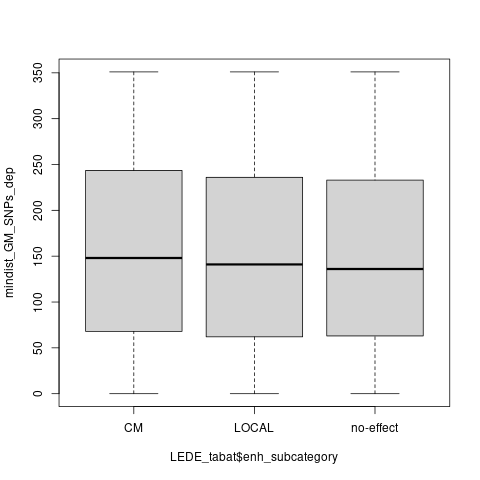

In [64]:
%%R
# add GM RSID if in dependent peak 
dep_GM_snp_info_tab = get_SNPs_in_deppeak_info_plus(LEDE_tabat,atac_tabn)
## above should be computing the sum of all columns in atac_tabn for the GM dep snp (partially redundant bc done again below..)

# choose the SNP in the dep peak that is closest to the peak center
mindist_GM_SNPs_dep = sapply(dep_GM_snp_info_tab,function(i){
  if(is.na(i$depGMSNP_dist_to_dep_peak_center[1])){
    return(NA)} 
  if (!is.na(i$depGMSNP_dist_to_dep_peak_center[1])){
    return(min(i$depGMSNP_dist_to_dep_peak_center,na.rm=T))}
})
boxplot(mindist_GM_SNPs_dep~LEDE_tabat$enh_subcategory)
print(table(!is.na(mindist_GM_SNPs_dep),LEDE_tabat$enh_subcategory))

# add the mindist chosen dep GM SNP to the master table
LEDE_taba_f= cbind(LEDE_tabat,do.call(rbind,lapply(dep_GM_snp_info_tab,function(x){
  if(is.na(x$depGMSNP_dist_to_dep_peak_center[1])){
    return(data.frame(x[1,]))}
  if (!is.na(x$depGMSNP_dist_to_dep_peak_center[1])){
    return(data.frame(x[which.min(x$depGMSNP_dist_to_dep_peak_center),]))}
})))

print(head(LEDE_taba_f))





In [65]:
%%R

atacn_lead = get_dom_ASA_in_GM(snp_tab = LEDE_taba_f,encode_map = atac_tabn,encode_cids = c(7,8),cnames = c("ATAC_caQTL_ref","ATAC_caQTL_alt","ATAC_caQTL_more","ATAC_caQTL_less"))

LEDE_ASAtab = get_dep_ASA_in_GM(snp_tab = atacn_lead,encode_map = atac_tabn,encode_cids = c(7,8),cnames = c("ATAC_dep_ref","ATAC_dep_alt","ATAC_dep_more","ATAC_dep_less"))

print(head(LEDE_ASAtab))



      Peak  Chr     Pos        RsID Ref Alt     AF Inside_Peak    P_Lead
7        7 chr1  565286   rs1578391   C   T 0.5978           1 0.9985614
222    213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.1  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
222.2  213 chr1 2508343 rs200553981   G   C 0.3500           1 0.9999242
287    277 chr1 3820005  rs10909828   G   A 0.3450           1 0.9999658
296    286 chr1 4327635   rs2101576   C   T 0.5500           1 0.9997817
           Beta       SE  Log10_BF Chr Pos_Left Pos_Right Peak      GC
7      0.886884 0.188153  3.085214   1   565005    565787    7 43.0396
222    0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.1  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
222.2  0.226942 0.024615 11.116547   1  2507916   2508523  213 59.2105
287   -0.654595 0.049849 19.692796   1  3819984   3820189  277 58.7379
296   -0.666789 0.041505 25.445000   1  4327332   4328105  286 

296             NA           NA            NA            NA


### add genotype annotation information in GM12878 for each SNP

In [68]:
%%R
vcf <- read.vcfR( "/home/.../ALL.phase3_v5b.20130502.LeadSNPs.NA12878.vcf.gz", verbose = FALSE )
print(head(vcf))

dfchrom = as.data.frame(vcf@fix)[,1:7]
dfgt = as.data.frame(vcf@gt)[,1:2]

print(head(dfgt))
print(head(dfchrom))



[1] "***** Object of class 'vcfR' *****"
[1] "***** Meta section *****"
[1] "##fileformat=VCFv4.1"
[1] "##FILTER=<ID=PASS,Description=\"All filters passed\">"
[1] "##fileDate=20150218"
[1] "##reference=ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/refe [Truncated]"
[1] "##source=1000GenomesPhase3Pipeline"
[1] "##contig=<ID=1,assembly=b37,length=249250621>"
[1] "First 6 rows."
[1] 
[1] "***** Fixed section *****"
     CHROM POS       ID           REF ALT QUAL  FILTER
[1,] "1"   "565286"  "rs1578391"  "C" "T" "100" "PASS"
[2,] "1"   "842362"  "rs28540380" "C" "T" "100" "PASS"
[3,] "1"   "968226"  "rs3121560"  "C" "A" "100" "PASS"
[4,] "1"   "1186502" "rs6603785"  "A" "T" "100" "PASS"
[5,] "1"   "1353380" "rs11488462" "T" "C" "100" "PASS"
[6,] "1"   "1355583" "rs1781133"  "C" "A" "100" "PASS"
[1] 
[1] "***** Genotype section *****"
     FORMAT NA12878
[1,] "GT"   "0|1"  
[2,] "GT"   "0|0"  
[3,] "GT"   "0|0"  
[4,] "GT"   "0|0"  
[5,] "GT"   "0|0"  
[6,] "GT"   "0|0"  
[1] 
[1] "Uni

In [77]:
%%R

LEDE_ASAtab$GM_LEAD_RSID_geno = dfgt$NA12878[match(LEDE_ASAtab$RsID,dfchrom$ID)]
LEDE_ASAtab$GM_LEAD_RSID_qual= dfchrom$QUAL[match(LEDE_ASAtab$RsID,dfchrom$ID)]
LEDE_ASAtab$GM_LEAD_RSID_pass= dfchrom$FILTER[match(LEDE_ASAtab$RsID,dfchrom$ID)]

LEDE_ASAtab$lead_geno_label = 'NA'
LEDE_ASAtab$lead_geno_label[LEDE_ASAtab$GM_LEAD_RSID_geno=='0|1' | LEDE_ASAtab$GM_LEAD_RSID_geno=='1|0'] = 'HET'
LEDE_ASAtab$lead_geno_label[LEDE_ASAtab$GM_LEAD_RSID_geno=='0|0' ] = 'REF'
LEDE_ASAtab$lead_geno_label[LEDE_ASAtab$GM_LEAD_RSID_geno=='1|1' ] = 'ALT'

LEDE_ASAtab$lead_LCL_actstate = c('REF','ALT')[c(1,2)[as.integer(LEDE_ASAtab$Beta>0)+1]]

LEDE_ASAtab$lead_gm_actstate = 'NA'
LEDE_ASAtab$lead_gm_actstate[LEDE_ASAtab$lead_geno_label=='HET'] = 'het'
LEDE_ASAtab$lead_gm_actstate[(LEDE_ASAtab$lead_geno_label=='REF' & LEDE_ASAtab$lead_LCL_actstate=='REF') | (LEDE_ASAtab$lead_geno_label=='ALT' & LEDE_ASAtab$lead_LCL_actstate=='ALT')] = 'homo_more'
LEDE_ASAtab$lead_gm_actstate[(LEDE_ASAtab$lead_geno_label=='REF' & LEDE_ASAtab$lead_LCL_actstate=='ALT') | (LEDE_ASAtab$lead_geno_label=='ALT' & LEDE_ASAtab$lead_LCL_actstate=='REF')] = 'homo_less'

print(tail(LEDE_ASAtab))

print(table(!is.na(LEDE_ASAtab$GM_LEAD_RSID_geno),LEDE_ASAtab$enh_subcategory))
print(table(LEDE_ASAtab$GM_LEAD_RSID_pass,LEDE_ASAtab$enh_subcategory))
print(table(LEDE_ASAtab$lead_gm_actstate[!duplicated(LEDE_ASAtab$Peak)],LEDE_ASAtab$enh_subcategory[!duplicated(LEDE_ASAtab$Peak)]))

         Peak  Chr       Pos       RsID Ref Alt      AF Inside_Peak    P_Lead
31476   29217 chr2  62408114 rs13004362   G   C 0.28005           1 0.2656618
31476.1 29217 chr2  62408114 rs13004362   G   C 0.28005           1 0.2656618
32257   29972 chr2  70237472 rs11126258   G   T 0.06500           1 0.3867709
32257.1 29972 chr2  70237472 rs11126258   G   T 0.06500           1 0.3867709
34401   32046 chr2 102372131  rs6543094   T   C 0.75000           1 0.3467704
34401.1 32046 chr2 102372131  rs6543094   T   C 0.75000           1 0.3467704
             Beta       SE  Log10_BF Chr  Pos_Left Pos_Right  Peak      GC
31476    0.033513 0.046526 -1.720579   2  62407956  62408600 29217 43.7209
31476.1  0.033513 0.046526 -1.720579   2  62407956  62408600 29217 43.7209
32257   -0.023992 0.052718 -1.733415   2  70237165  70238157 29972 49.5468
32257.1 -0.023992 0.052718 -1.733415   2  70237165  70238157 29972 49.5468
34401    0.002010 0.028256 -2.047814   2 102371729 102372607 32046 43.1172
3440

        ATAC_dep_ref ATAC_dep_alt ATAC_dep_more ATAC_dep_less GM_LEAD_RSID_geno
31476             NA           NA            NA            NA               0|1
31476.1           NA           NA            NA            NA               0|1
32257             NA           NA            NA            NA               0|0
32257.1           NA           NA            NA            NA               0|0
34401             NA           NA            NA            NA               1|1
34401.1           NA           NA            NA            NA               1|1
        GM_LEAD_RSID_qual GM_LEAD_RSID_pass lead_geno_label lead_LCL_actstate
31476                 100              PASS             HET               ALT
31476.1               100              PASS             HET               ALT
32257                 100              PASS             REF               REF
32257.1               100              PASS             REF               REF
34401                 100              PASS       

In [ ]:
%%R
## write.csv(LEDE_ASAtab,'/home/.../Interim_Master_table_LEAD_DEP_pairs_noeffect_local_cm_AllspInfo.csv')